## Transfer Learning(전이학습)

### 1 . Package load

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

### 2 . Data load, 정규화

In [25]:
# 학습을 위한 데이터 증가(Augmentation)와 일반화하기
# 단지 검증을 위한 일반화하기
__file__ = 'CNN_AntBeeClassifier.py'

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

path = {x: os.path.join(os.path.dirname(os.path.abspath(__file__)),data_dir,x)
                for x in ['train', 'val']}

# path['train']은 train set의 경로
# path['val']은 val set의 경로
# join은 문자열을 이어 붙여주는 함수

image_datasets = {x: datasets.ImageFolder(path[x],
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = { 'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                             shuffle=True, num_workers=0),
                'val' : torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,
                                             shuffle=True, num_workers=0) }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#dataset_sizes['train'] = train set 사진 갯수
#dataset_sizes['val'] = val set 사진 갯수

class_names = image_datasets['train'].classes
#class_names = ['ants', 'bees']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#GPU가 이용 가능한지를 확인


cpu


### 3 . 이미지 시각화

data_loader 선언 완료, 경로 입력 완료했으니, data 잘 load 되는지 확인.

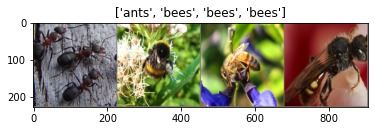

In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean   # 정규화를 해제
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 4로 했으니 사진 4장이 로드된다.
inputs, classes = next(iter(dataloaders['train']))

# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
out = torchvision.utils.make_grid(inputs)

# 이미지를 출력한다.
imshow(out, title=[class_names[x] for x in classes])


### 4 . 모델 정의하기

In [27]:
model_ft = models.resnet18(pretrained=True) 
num_ftrs = model_ft.fc.in_features 
model_ft.fc = nn.Linear(num_ftrs, 2) 

model_ft = model_ft.to(device)


### 5. 손실함수와 Optimizer 정의하기

In [28]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


### 6 . train, test

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #시작 시간을 기록(총 소요 시간 계산을 위해)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train mode와 validation mode 순으로 진행
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #dataloader로부터 dataset과 그에 해당되는 label을 불러옴
                inputs = inputs.to(device) #GPU로 입력데이터를 올림
                labels = labels.to(device) #GPU로 label을 올림

                # zero the parameter gradients
                optimizer.zero_grad() #Gradient를 0으로 초기화

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정
                    loss = criterion(outputs, labels) 

                    # backward + optimize only if in training phase
                    if phase == 'train': # training 모드에서는 weight를 update한다.
                        loss.backward() #backward
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 7 . 모델 예측치에 대한 시각화하기

In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 8 . training accuracy, valid accuracy 확인

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6933 Acc: 0.6680
val Loss: 0.3022 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5062 Acc: 0.8033
val Loss: 0.2529 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5446 Acc: 0.7500
val Loss: 0.2844 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5102 Acc: 0.7869
val Loss: 0.4506 Acc: 0.8497

Epoch 4/24
----------
train Loss: 0.6327 Acc: 0.7500
val Loss: 0.4422 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4359 Acc: 0.8443
val Loss: 0.4166 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.4300 Acc: 0.8361
val Loss: 0.2472 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4274 Acc: 0.8156
val Loss: 0.2493 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3215 Acc: 0.8484
val Loss: 0.2066 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3563 Acc: 0.8279
val Loss: 0.1991 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3196 Acc: 0.8689
val Loss: 0.2253 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3004 Acc: 0.8648
val Loss: 0.1927 Acc: 0.9216

Ep

### 9 . 모델 예측 시각화

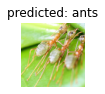

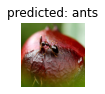

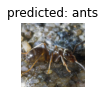

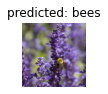

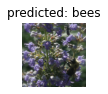

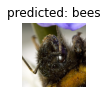

In [32]:
visualize_model(model_ft)